# Tutorial: Convert NETCDF files to OpenVisus

## Python Setup

Install Python packages:
Note: if you need the OpenVisus Viewer, replace the `OpenVisusNoGui` python package with full fledged `OpenVisus`.

```
python -m pip install --upgrade pip
python -m pip install OpenVisusNoGui openvisuspy xmltodict numpy colorcet netCDF4
```

Also you may want to install some NETCDF tools to verify, for example, a file version:

```
sudo apt install netcdf-bin
ncdump -k psl_day_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_20000101-20141231.nc
netCDF-4
```

## Import OpenVisus and openvisuspy

In [1]:
import os,sys,numpy as np

# debug mode, uncomment for internal/developer mode only
# sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
# sys.path.append(r"C:\projects\openvisuspy\src")

import OpenVisus as ov
import openvisuspy as ovy

## Load the NETCDF file 

In [2]:
import netCDF4 as nc
ds = nc.Dataset('psl_day_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_20000101-20141231.nc')

## Inspect the NetCDF structure

A NetCDF file has three basic parts: metadata, dimensions and variables. 
Variables contain both metadata and data. 
Print its structure

In [3]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.7 CMIP-6.2
    creation_date: 2019-08-17T11:05:53Z
    description: CMIP6 historical
    title: CNRM-CM6-1-HR model output prepared for CMIP6 and CMIP / historical simulation
    activity_id: CMIP
    contact: contact.cmip@meteo.fr
    data_specs_version: 01.00.21
    dr2xml_version: 1.16
    experiment_id: historical
    experiment: all-forcing simulation of the recent past
    external_variables: areacella
    forcing_index: 2
    frequency: day
    further_info_url: https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFACS.CNRM-CM6-1-HR.historical.none.r1i1p1f2
    grid: data regridded to a 359 gaussian grid (360x720 latlon) from a native atmosphere T359l reduced gaussian grid
    grid_label: gr
    nominal_resolution: 50 km
    initialization_index: 1
    institution_id: CNRM-CERFACS
    institution: CNRM (Centre National de Recherches Meteorologiques, Toulouse 31057, France), CERFAC

## Print the NetCDF **dimensions**

In [4]:
from pprint import pprint
pprint(ds.dimensions)

{'axis_nbounds': <class 'netCDF4._netCDF4.Dimension'>: name = 'axis_nbounds', size = 2,
 'lat': <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 360,
 'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 720,
 'time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 5479}


## Print  the NetCDF **variables**

Variables contain binary data, to be converted later

In [8]:
from pprint import pprint
pprint(ds.variables)

dict_values([<class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    axis: Y
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used, <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    axis: X
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used, <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    axis: T
    standard_name: time
    long_name: Time axis
    calendar: gregorian
    units: days since 1850-01-01 00:00:00
    time_origin: 1850-01-01 00:00:00
    bounds: time_bounds
unlimited dimensions: time
current shape = (5479,)
filling on, default _FillValue of 9.969209968386869e+36 used, <class 'netCDF4._netCDF4.Variable'>
float64 time_bounds(time, axis_nbounds)
unlimited dimensions: time
current shape = (5479, 2)
f

## Choose the variable to convert 

The variable we are interested in converting is `ps1` i.e. the *Sea Level Pressure*

In [7]:
var=ds.variables['psl']
print(var)

<class 'netCDF4._netCDF4.Variable'>
float32 psl(time, lat, lon)
    long_name: Sea Level Pressure
    units: Pa
    online_operation: average
    cell_methods: area: time: mean
    interval_operation: 900 s
    interval_write: 1 d
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: 
    description: Sea Level Pressure
    history: none
    cell_measures: area: areacella
    standard_name: air_pressure_at_mean_sea_level
unlimited dimensions: time
current shape = (5479, 360, 720)
filling on


## Read the NetCDF binary  data in memory

In [10]:
import time
t1 = time.time()
data=var[:,:,:]
num_timesteps,H,W=data.shape[0], data.shape[1], data.shape[2]
m,M=np.min(data),np.max(data)
read_sec=time.time()-t1
print(f"NetCDF file loaded in {read_sec} seconds dtype={data.dtype} num_timesteps={num_timesteps} W={W} H={H} m={m} M={M}")

NetCDF file loaded in 23.107910871505737 seconds dtype=float32 num_timesteps=5479 W=720 H=360 m=91981.7109375 M=108768.9765625


## Create the OpenVisus file

In [12]:
arco="modvisus"

idx_filename="tmp/netcdf/tutorial-1/visus.idx"
db=ov.CreateIdx(
    url=idx_filename, 
    dims=[W,H], 
    fields=[ov.Field("data",str(data.dtype),"row_major")], 
    compression="raw", 
    time=[0,num_timesteps,"time_%04d/"], 
    arco=arco)

print(db.getDatasetBody().toString())
print("Dataset created")

<dataset url="test1/visus.idx" cache_dir="" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V0010101010101010101" />
		<box value="0 720 0 360" />
		<bitsperblock value="16" />
		<blocksperfile value="8" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%04x.bin" />
		<missing_blocks value="False" />
		<arco value="0" />
		<time_template value="time_%04d/" />
		<field name="data" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="float32" />
		<timestep from="0" to="5479" step="1" />
	</idxfile>
</dataset>
Dataset created


## Write uncompressed OpenVisus binary data  

In [14]:
t1 = time.time()
for timestep in range(num_timesteps):
    db.write(data[timestep,:,:],time=timestep)
write_sec=time.time() - t1
print(f"Wrote new timestep={timestep} done in {write_sec} seconds")

Wrote new timestep=5478 done in 41.81589412689209 seconds


### Compress OpenVisus binary data 

NOTE that this step can be slow since it' doing a lot of random reading/writings. 
You may use `lz4` to speed up this step, but you will get bigger files.

In [17]:
t1 = time.time()
algorithm="zip"
db.compressDataset([algorithm])
compress_sec=time.time()-t1
print(f"Compressed timestep={timestep} done in {compress_sec} seconds")

Compressed timestep=5478 done in 182.16820549964905 seconds


## Display a  Region of Interest

Read data from OpenVisus at a certain timestep

In [18]:
data=db.read(x=[0,W],y=[0,H],time=num_timesteps//2)

Display the data using `matplotlib`:

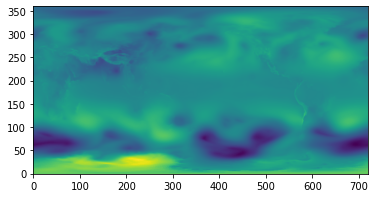

In [20]:
import matplotlib.pyplot as plt

def ShowData(data):
    ratio=float(data.shape[1])/data.shape[0]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()
        
ShowData(data)

## Final considerations

We converted the binary data as a 2d Dataset `(lat,log)` with timestep considered as a special dimension. In fact you will see the data is internally organized in different folders depending on the timesteps (e.g. `visus\time_0000\0000.bin`, `visus\time_0001\0000.bin` etc.).  

You may also convert the binary data as a full 3D dataset: `(time,lat,lon)`. This modality makes more sense if you need to access/display slices related to different timesteps, for example the evolution of the pressure at a certain `lon` for some time range. The variation to the code above are minimal.